# <font style="color:blue">Project 3: Object Detection</font>


#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Plot Ground Truth Bounding Boxes</h3></td> <td><h3>20</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Training</h3></td> <td><h3>25</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Inference</h3></td> <td><h3>15</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>COCO Detection Evaluation</h3></td> <td><h3>25</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Run Inference on a Video</h3></td> <td><h3>15</h3></td> </tr>
    </table>
</div>


# <font style="color:purple">Download the Dataset</font> 

**[Download the Vehicle registration plate](https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1)**


Download the Vehicle Registration Plate dataset from [here](https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1) and unzip it. 

We will have the following directory structure:

```
Dataset
├── train
│   └── Vehicle registration plate
│       └── Label
└── validation
    └── Vehicle registration plate
        └── Label
```

Unzipping the file will give you a directory `Dataset`. This directory has two folder `train` and `validation`. Each train and validation folder has `Vehicle registration plate`  folder with `.jpg` images and a folder `Labels`.  `Labels` folder has bounding box data for the images.


For example,
For image: `Dataset/train/Vehicle registration plate/bf4689922cdfd532.jpg`
Label file is  `Dataset/train/Vehicle registration plate/Label/bf4689922cdfd532.txt`

There are one or more lines in each `.txt` file. Each line represents one bounding box.
For example,
```
Vehicle registration plate 385.28 445.15 618.24 514.225
Vehicle registration plate 839.68 266.066462 874.24 289.091462
```

We have a single class detection (`Vehicle registration plate detection`) problem. So bounding box details start from the fourth column in each row.

Representation is in `xmin`, `ymin`, `xmax`, and `ymax` format.

**It has `5308` training and `386` validation dataset.**

Data is downloaded from [Open Images Dataset](https://storage.googleapis.com/openimages/web/index.html)

In [3]:
import zipfile
import tarfile
from pathlib import Path


dataset_path = "Dataset.zip"  
extract_to = "." 


Path(extract_to).mkdir(parents=True, exist_ok=True)


if dataset_path.endswith(".zip"):
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"✅ Extracted {dataset_path} into {extract_to}")

✅ Extracted Dataset.zip into .


#  <font style="color:green">1. Plot Ground Truth Bounding Boxes [20 Points]</font> 

**You have to show three images from validation data with the bounding boxes.**

The plotted images should be similar to the following:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g1.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g2.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g3.png'>



In [1]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from PIL import Image
import random
from collections import defaultdict
import json
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

Using device: cuda


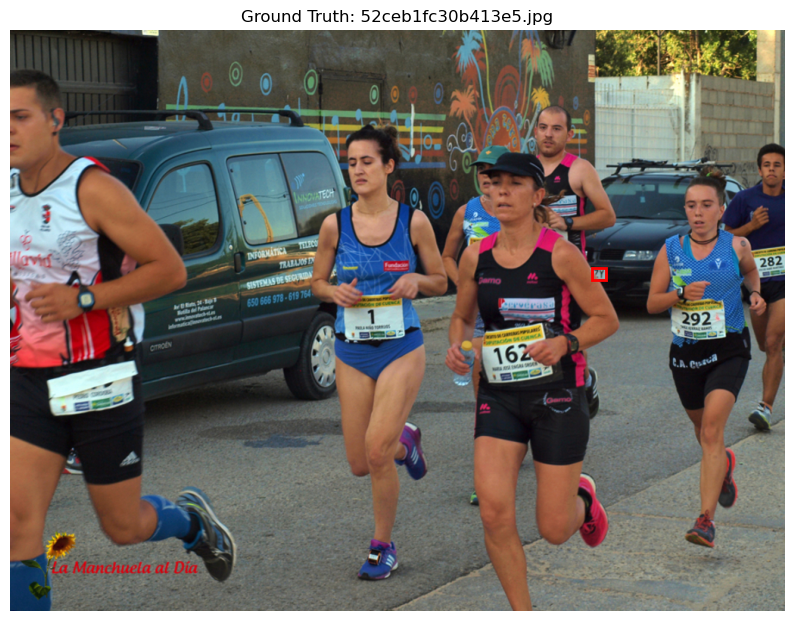

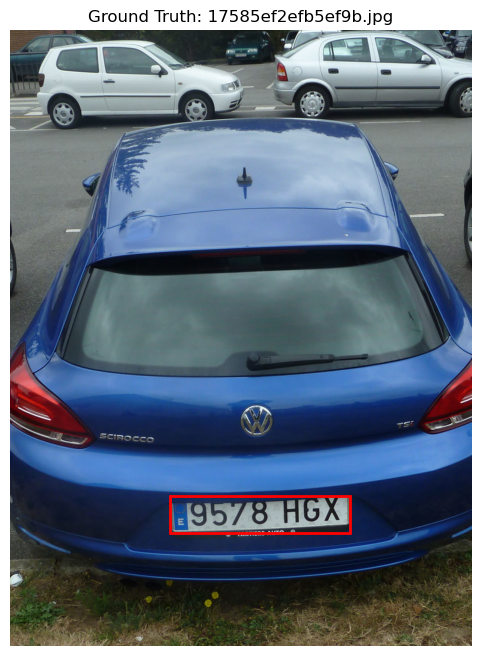

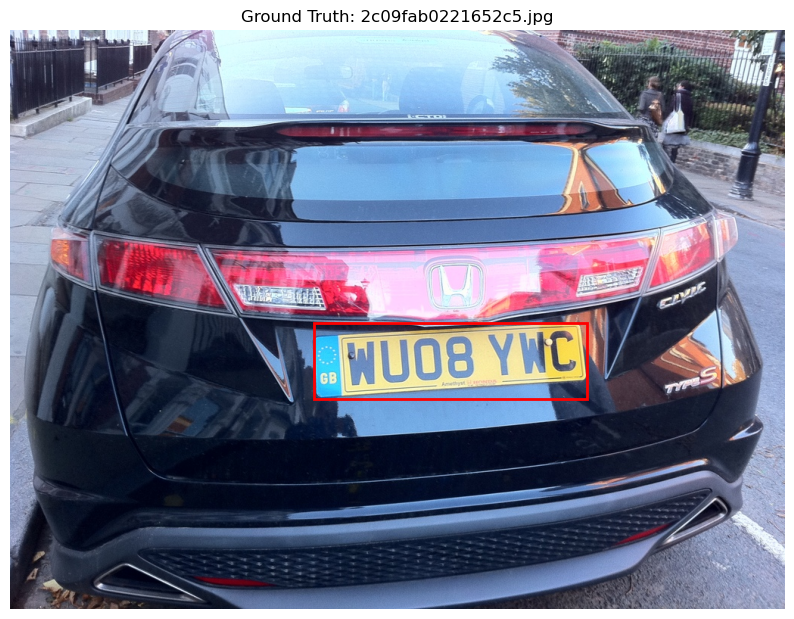

In [15]:
def load_ground_truth_labels(label_path):
    """Load bounding box labels from a .txt file."""
    bboxes = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()

            if len(parts) < 7:  
                continue 
            try:
                
                bbox = list(map(float, parts[3:7]))
                bboxes.append(bbox)
            except ValueError:
                print(f"Warning: Could not parse line: {line}")
                continue
    return bboxes

def plot_image_with_bboxes(image_path, bboxes, title="Ground Truth"):
    """Plot an image with its bounding boxes."""
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.imshow(img_rgb)

    for bbox in bboxes:
        xmin, ymin, xmax, ymax = bbox
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             fill=False, color='red', linewidth=2)
        ax.add_patch(rect)

    ax.set_title(title)
    ax.axis('off')
    plt.show()


val_images_dir = 'Dataset/validation/Vehicle registration plate'
val_labels_dir = 'Dataset/validation/Vehicle registration plate/Label'


image_files = [f for f in os.listdir(val_images_dir) if f.endswith('.jpg')]


selected_images = random.sample(image_files, 3)


for img_file in selected_images:
    img_path = os.path.join(val_images_dir, img_file)
    label_file = img_file.replace('.jpg', '.txt')
    label_path = os.path.join(val_labels_dir, label_file)
    
    bboxes = load_ground_truth_labels(label_path)
    plot_image_with_bboxes(img_path, bboxes, f"Ground Truth: {img_file}")

#  <font style="color:green">2. Training [25 Points]</font> 

- **Write your training code in this section.**

- **You also have to share ([shared logs example](https://tensorboard.dev/experiment/JRtnsKbwTaq1ow6nPLPGeg)) the loss plot of your training using tensorboard.dev.** 

How to share TensorBoard logs using tensorboard.dev find [here](https://courses.opencv.org/courses/course-v1:OpenCV+OpenCV-106+2019_T1/courseware/b1c43ffe765246658e537109e188addb/d62572ec8bd344db9aeae81235ede618/4?activate_block_id=block-v1%3AOpenCV%2BOpenCV-106%2B2019_T1%2Btype%40vertical%2Bblock%40398b46ddcd5c465fa52cb4d572ba3229).

Epoch 1/10: 100%|██████████| 2654/2654 [03:59<00:00, 11.07it/s]


Epoch 1, Loss: 0.1341


Epoch 2/10: 100%|██████████| 2654/2654 [03:46<00:00, 11.72it/s]


Epoch 2, Loss: 0.1181


Epoch 3/10: 100%|██████████| 2654/2654 [03:50<00:00, 11.50it/s]


Epoch 3, Loss: 0.1142


Epoch 4/10: 100%|██████████| 2654/2654 [03:48<00:00, 11.61it/s]


Epoch 4, Loss: 0.1014


Epoch 5/10: 100%|██████████| 2654/2654 [03:48<00:00, 11.62it/s]


Epoch 5, Loss: 0.0972


Epoch 6/10: 100%|██████████| 2654/2654 [03:47<00:00, 11.69it/s]


Epoch 6, Loss: 0.0950


Epoch 7/10: 100%|██████████| 2654/2654 [03:49<00:00, 11.55it/s]


Epoch 7, Loss: 0.0921


Epoch 8/10: 100%|██████████| 2654/2654 [03:48<00:00, 11.62it/s]


Epoch 8, Loss: 0.0918


Epoch 9/10: 100%|██████████| 2654/2654 [03:49<00:00, 11.54it/s]


Epoch 9, Loss: 0.0917


Epoch 10/10: 100%|██████████| 2654/2654 [03:48<00:00, 11.63it/s]


Epoch 10, Loss: 0.0916


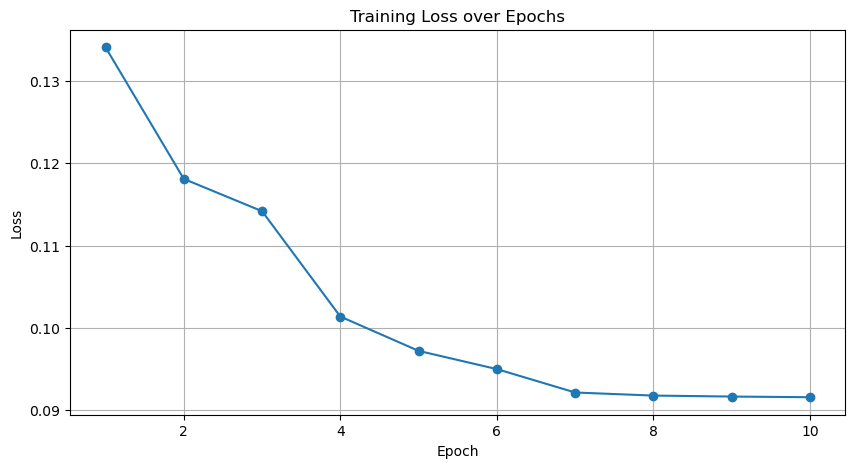

In [3]:
from torchvision.transforms import functional as F
class VehiclePlateDataset(torch.utils.data.Dataset):
    def __init__(self, root):
        self.root = root
        
        img_dir = os.path.join(root, "Vehicle registration plate")
        self.imgs = [f for f in sorted(os.listdir(img_dir)) if f.endswith('.jpg')]
        self.labels_dir = os.path.join(img_dir, "Label")

    def __getitem__(self, idx):
        img_file = self.imgs[idx]
        img_path = os.path.join(self.root, "Vehicle registration plate", img_file)
        label_file = img_file.replace('.jpg', '.txt')
        label_path = os.path.join(self.labels_dir, label_file)
        

        img = Image.open(img_path).convert("RGB")
        img = F.to_tensor(img) 


        bboxes = []
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 7:
                    bbox = list(map(float, parts[3:7])) 
                    bboxes.append(bbox)
        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        labels = torch.ones((len(bboxes),), dtype=torch.int64) 

        target = {
            "boxes": bboxes,
            "labels": labels
        }

        return img, target

    def __len__(self):
        return len(self.imgs)

def get_model(num_classes):

    model = fasterrcnn_resnet50_fpn(pretrained=True)
    

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
   
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

train_dataset = VehiclePlateDataset('Dataset/train')
val_dataset = VehiclePlateDataset('Dataset/validation')


train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=lambda x: tuple(zip(*x))
)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=lambda x: tuple(zip(*x))
)


num_classes = 2  
model = get_model(num_classes)
model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):

        images = [img.to(device) for img in images] 
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses.item()
    
    
    lr_scheduler.step()
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss:.4f}")


torch.save(model.state_dict(), 'faster_rcnn_vehicle_plate.pth')


plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

#  <font style="color:green">3. Inference [15 Points]</font> 

**You have to make predictions from your trained model on three images from the validation dataset.**

The plotted images should be similar to the following:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p1.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p2.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p3.png'>




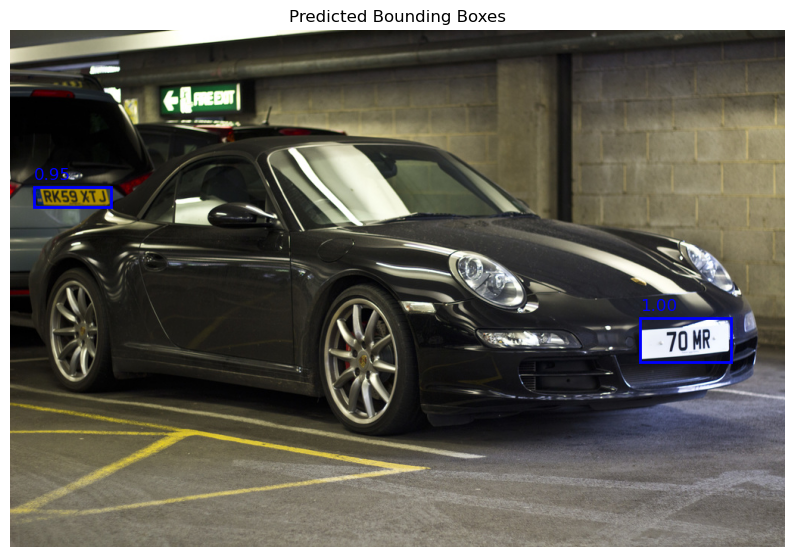

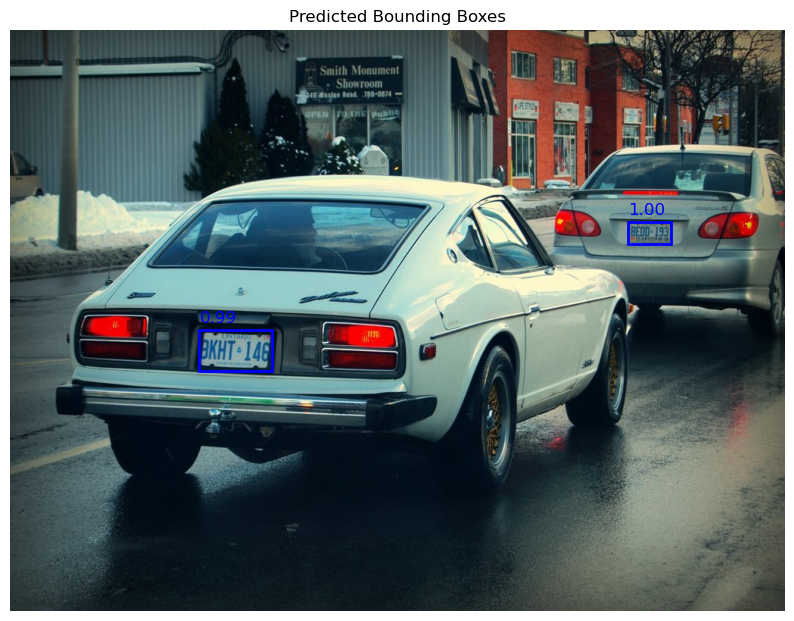

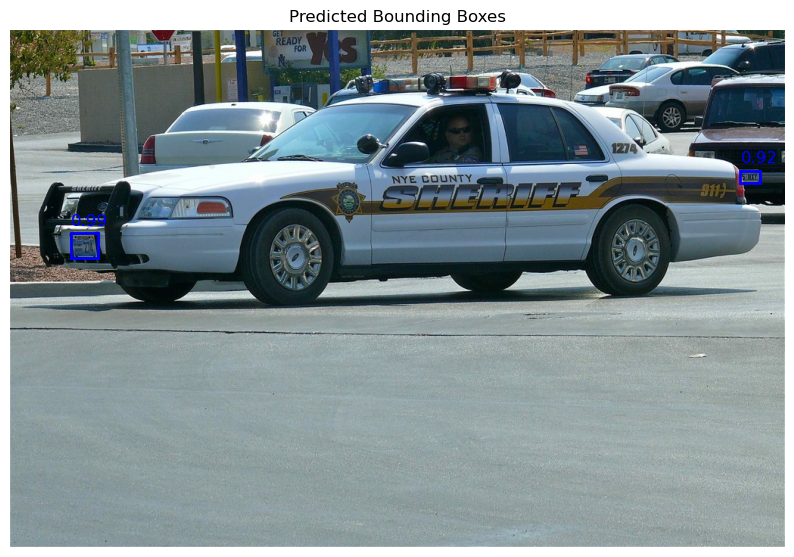

In [4]:

model.load_state_dict(torch.load('faster_rcnn_vehicle_plate.pth'))
model.eval()

def plot_prediction_results(image_path, prediction, threshold=0.5):
    
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.imshow(img_rgb)
    

    scores = prediction['scores'].detach().cpu().numpy()
    boxes = prediction['boxes'].detach().cpu().numpy()
    
    for i, score in enumerate(scores):
        if score > threshold:
            xmin, ymin, xmax, ymax = boxes[i]
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 fill=False, color='blue', linewidth=2)
            ax.add_patch(rect)
            ax.text(xmin, ymin-10, f'{score:.2f}', color='blue', fontsize=12)
    
    ax.set_title("Predicted Bounding Boxes")
    ax.axis('off')
    plt.show()


for img_file in selected_images: 
    img_path = os.path.join(val_images_dir, img_file)
    img = Image.open(img_path).convert("RGB")
    img_tensor = F.to_tensor(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        prediction = model(img_tensor)[0]
    
    plot_prediction_results(img_path, prediction)

#  <font style="color:green">4. COCO Detection Evaluation [25 Points]</font> 

**You have to evaluate your detection model on COCO detection evaluation metric.**

For your reference here is the coco evaluation metric chart:


---

<img src="https://www.learnopencv.com/wp-content/uploads/2020/03/c3-w9-coco_metric.png">

---

#### <font style="color:red">The expected `AP` (primary challenge metric) is more than `0.5`.</font>

**The expected output should look similar to the following:**

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.886
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.629
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.653
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.627
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.633
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.704
```



In [6]:
!pip install pycocotools

Defaulting to user installation because normal site-packages is not writeable


In [12]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def convert_to_coco_format(dataset, model, device, threshold=0.5):
    """Convert predictions to COCO format for evaluation."""
    coco_results = []
    image_id = 1
    
    for img_file in tqdm(os.listdir(val_images_dir), desc="Converting to COCO format"):
        if not img_file.endswith('.jpg'):
            continue
            
        img_path = os.path.join(val_images_dir, img_file)
        img = Image.open(img_path).convert("RGB")
        img_tensor = F.to_tensor(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            prediction = model(img_tensor)[0]
        
        scores = prediction['scores'].detach().cpu().numpy()
        boxes = prediction['boxes'].detach().cpu().numpy()
        
        for i, score in enumerate(scores):
            if score > threshold:
                xmin, ymin, xmax, ymax = boxes[i]
                width = xmax - xmin
                height = ymax - ymin
                coco_results.append({
                    "image_id": image_id,
                    "category_id": 1, 
                    "bbox": [float(xmin), float(ymin), float(width), float(height)],
                    "score": float(score)
                })
        
        image_id += 1
    
    return coco_results


coco_predictions = convert_to_coco_format(val_dataset, model, device)


coco_gt = {
    "info": {
        "description": "Vehicle Registration Plate Detection Dataset",
        "version": "1.0",
        "year": 2025,
        "contributor": "aikarimi",
        "date_created": "2025-04-05"
    },
    "licenses": [
        {
            "id": 1,
            "name": "Unknown",
            "url": ""
        }
    ],
    "images": [],
    "annotations": [],
    "categories": [{"id": 1, "name": "Vehicle registration plate"}]
}

annotation_id = 1  
image_id = 1

for img_file in os.listdir(val_images_dir):
    if not img_file.endswith('.jpg'):
        continue
    img_path = os.path.join(val_images_dir, img_file)
    img = cv2.imread(img_path)
    height, width, _ = img.shape
    coco_gt["images"].append({
        "id": image_id,
        "width": width,
        "height": height,
        "file_name": img_file
    })
    
    label_file = img_file.replace('.jpg', '.txt')
    label_path = os.path.join(val_labels_dir, label_file)
    if not os.path.exists(label_path):
        image_id += 1
        continue
        
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 7:
                continue
            try:
                xmin, ymin, xmax, ymax = map(float, parts[3:7])
                width = xmax - xmin
                height = ymax - ymin
                
                coco_gt["annotations"].append({
                    "id": annotation_id,           
                    "image_id": image_id,
                    "category_id": 1,
                    "bbox": [xmin, ymin, width, height],
                    "area": width * height,
                    "iscrowd": 0
                })
                annotation_id += 1  
            except Exception as e:
                print(f"Skipping invalid line in {label_file}: {line}")
    
    image_id += 1


with open('coco_gt.json', 'w') as f:
    json.dump(coco_gt, f)


with open('coco_pred.json', 'w') as f:
    json.dump(coco_predictions, f)


coco_gt = COCO('coco_gt.json')
coco_dt = coco_gt.loadRes('coco_pred.json')
coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

Converting to COCO format: 100%|██████████| 387/387 [00:11<00:00, 32.92it/s]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.630
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.884
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.746
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.329
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.710
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.574
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.687
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

# <font style="color:green">5. Run Inference on a Video [15 Points]</font>

#### [Download the Input Video](https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1)

**You have to run inference on a video.** 

You can download the video from [here](https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1).

#### <font style="color:red">Upload the output video on youtube and share the link. Do not upload the video in the lab.</font>

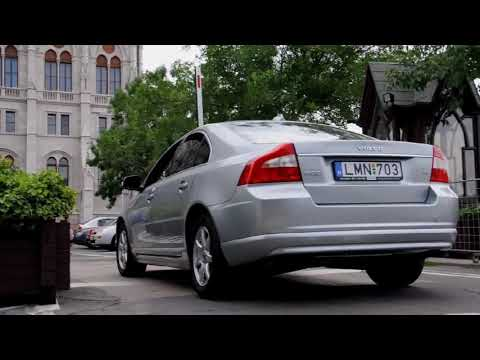

In [1]:
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("18HWHCevFdU", width=640, height=360)
display(video)

**Your output video should have a bounding box around the vehicle registration plate.**

In [ ]:
video = YouTubeVideo("5SgCuee7AMs", width=640, height=360)
display(video)

**You can use the following sample code to read and write a video.**

In [13]:
def run_inference_on_video(video_path, output_path, model, device, threshold=0.5):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file")
        return
    

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
        img_tensor = F.to_tensor(img_pil).unsqueeze(0).to(device)
        
        
        with torch.no_grad():
            prediction = model(img_tensor)[0]
        
        
        scores = prediction['scores'].detach().cpu().numpy()
        boxes = prediction['boxes'].detach().cpu().numpy()
        
        for i, score in enumerate(scores):
            if score > threshold:
                xmin, ymin, xmax, ymax = boxes[i]
                cv2.rectangle(frame, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)
                cv2.putText(frame, f'{score:.2f}', (int(xmin), int(ymin)-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        out.write(frame)
    
    cap.release()
    out.release()
    print(f"Output video saved to {output_path}")


input_video_path = 'projet3-input-video.mp4'
output_video_path = 'output_video.mp4'


run_inference_on_video(input_video_path, output_video_path, model, device)



Output video saved to output_video.mp4


In [14]:
print("Click the below link to watch the output video on youtube:")
print("https://youtu.be/Ip4pCRA3S94")

Click the below link to watch the output video on youtube:
https://youtu.be/Ip4pCRA3S94
